In [1]:
import numpy as np
import scipy.cluster.hierarchy as sch
import datetime

import matplotlib.pyplot as plt
import seaborn

import pandas
import pandas_datareader as pdr

import lpa

%matplotlib inline
seaborn.set(font='Helvetica')
seaborn.set_style('white')
seaborn.set_style("ticks")

In [2]:
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2017, 1, 1)

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbol_dict_2 = {
    'AAPL' : 'Apple',
    'GOOG' : 'Google',
    'MSFT' : 'Microsoft',
    'FB'   : 'Facebook',
    'ORCL' : 'Oracle',
    'INTC' : 'Intel',
    'CSCO' : 'Cisco',
    'IBM'  : 'IBM',
    'SAP'  : 'SAP',
    'AVGO' : 'Broadcom Limited',
    'DCM'  : 'NTT DOCOMO Inc',
    'TXN'  : 'Texas Instruments',
    'NVDA' : 'NVIDIA Corporation',
    'ADBE' : 'Adobe Systems',
    'CRM'  : 'Salesforce.com',
    'BIDU' : 'Baidu',
    'ITW'  : 'Illinois Tool Works',
    'YHOO' : 'Yahoo',
    'AMAT' : 'Applied Materials, Inc',
    'ADP'  : 'Automatic Data Processing',
    'ATVI' : 'Activision Blizzard',
    'VMW'  : 'Vmware',
    'CTSH' : 'Cognizand Technology SOlutions',
    'NXPI' : 'NXP Semiconductors',
    'NOK'  : 'Nokia Corporation',
    'ETN'  : 'Eaton Coporation',
    'INFY' : 'Infosys Limited',
    'EA'   : 'Electronic Arts',
    'HPQ'  : 'HP Inc',
    'INTU' : 'Intuit Inc',
    'MU'   : 'Micron Technology',
    'ADI'  : 'Analog Devices, Inc',
    'WDC'  : 'Western Digital Corporation',
    'FISV' : 'Fiserv',
    'WIT'  : 'Wipro Limited',
    'LRCX' : 'Lam Research Corporation',
    'DXC'  : 'DXC Technology Company',
    'KYO'  : 'Kyocera Corporation',
    'CERN' : 'Cerner Corporation',
    'ADSK' : 'Autodesk, Inc',
    'SYMC' : 'Symantec Corporation',
    'OMC'  : 'Omnicom Group, Inc',
    'SWKS' : 'Skyworks Solutions',
    'CHKP' : 'Check Point Software',
    'MCHP' : 'Microchip Technology',
    'XLNX' : 'Xilinx, Inc',
    'RHT'  : 'Red Hat, Inc',
    'STM'  : 'STMicroelectronics',
    'MSI'  : 'Motorola Solutions',
    'CA'   : 'CA Inc',
    'CTXS' : 'Citrix Systems',
    'LLL'  : 'L3 Technologies',
    'MXIM' : 'Maxim Integrated Products',
    'VRSK' : 'Verisk Analytics',
    'STX'  : 'Seagate Technology',
    'DOV'  : 'Dover Corporation',
    'PNR'  : 'Pentair',
    'JNPR' : 'Juniper Networks, Inc',
    'SNPS' : 'Synopysis, Inc',
    'ANSS' : 'ANSYS, Inc',
    'AMD'  : 'Advanced Micro Devices',
    'ASX'  : 'Advanced Semiconductor Engineering, Inc',
    'IPG'  : 'Interpublic Group of Companies, Inc',
    'URI'  : 'United Rentals',
}

for symbol in symbol_dict_2:
    symbol_dict[symbol] = symbol_dict_2[symbol]

symbol_dict = {
    'JNPR' : 'Juniper Networks, Inc',
    'SNPS' : 'Synopysis, Inc',
    'ANSS' : 'ANSYS, Inc',
    'AMD'  : 'Advanced Micro Devices',
    'ASX'  : 'Advanced Semiconductor Engineering, Inc',
    'IPG'  : 'Interpublic Group of Companies, Inc',
    'URI'  : 'United Rentals',    
}
    
symbols, names = np.array(list(symbol_dict.items())).T

quotes = []
for symbol in symbols:
    print symbol
    quotes.append(pdr.get_data_yahoo(symbol,start=d1,end=d2))

ANSS
IPG
SNPS
ASX
AMD
URI
JNPR


In [34]:
X = np.vstack([q['Adj Close'].as_matrix() for q in quotes]).astype(np.float)
X = np.log2(X)

filter_length = 21
ewma = np.vstack([pandas.stats.moments.ewma(X[i,:],halflife=filter_length) 
                  for i in range(X.shape[0])])
X -= ewma

times = range(X.shape[1])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


In [43]:
n_components = 6
n_lags = 1
lp = lpa.LPA(n_components,n_lags)
X_lat = lp.fit_predict_latent(X)

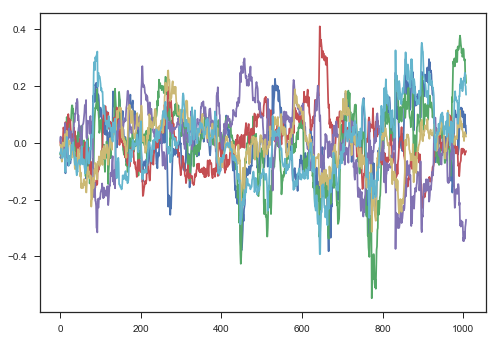

In [44]:
for i in range(n_components):
    plt.plot(times, X_lat[i,:])
plt.show()

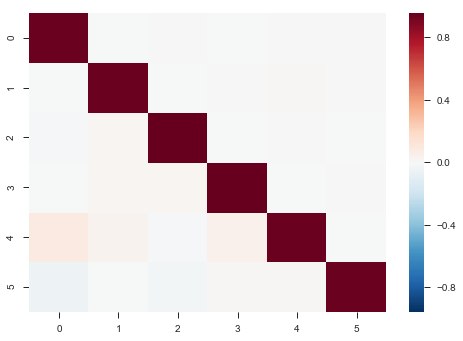

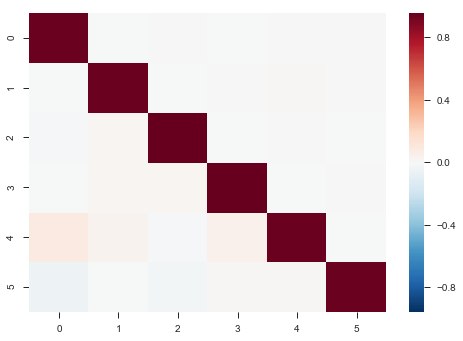

In [45]:
W,A,b = lp.get_model_params()
seaborn.heatmap(np.mean(A,axis=0))
plt.show()
seaborn.heatmap(A[0])
plt.show()

In [38]:
np.linalg.norm(A)

1.6663001440900269